# Integration of ZarrDataset with PyTorch's DataLoader (Advanced)

In [1]:
import zarrdataset as zds

import torch
from torch.utils.data import DataLoader, ChainDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = [
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001240.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001241.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001242.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001243.zarr",
]

### Extracting patches of size 128x128x32 `voxels` from a three-dimensional image

Sample the image randomly

In [3]:
patch_size = dict(Z=1, Y=128, X=128)
patch_sampler = zds.GridPatchSampler(patch_size=patch_size)

Transform the input data from uint16 to float16 with a torchvision pre-processing pipeline

In [4]:
import torchvision

img_preprocessing = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float16)
])

Pass the pre-processing function to ZarrDataset to beused when generating the samples

In [5]:
my_datasets = [zds.ZarrDataset(fn,
                               transform=img_preprocessing,
                               data_group="0",
                               source_axes="TCZYX",
                               patch_sampler=patch_sampler,
                               shuffle=True,
                               return_any_label=False,
                               return_positions=True)
              for fn in filenames]

### Create a ChainDataset from a set of ZarrDatasets that can be put together a single large dataset

In [6]:
my_chain_dataset = ChainDataset(my_datasets)

Make sure the chained_zarrdataset_worker_init function is passed to the DataLoader, so the workers can initialize the dataset correctly

In [7]:
my_dataloader = DataLoader(my_chain_dataset,
                           num_workers=0,
                           worker_init_fn=zds.chained_zarrdataset_worker_init,
                           batch_size=2
                           )

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [9]:
samples = []
positions = []
for i, (pos, sample) in enumerate(my_dataloader):
    positions += [p for p in pos]
    samples += [s for s in sample]

    print(f"Sample {i+1} with size {sample.shape}")

    if i > 3:
        # Take only five samples for illustration purposes
        break

samples = torch.cat(samples, dim=-1)

c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\boto3\compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Sample 1 with size torch.Size([2, 1, 2, 1, 128, 128])
Sample 2 with size torch.Size([2, 1, 2, 1, 128, 128])
Sample 3 with size torch.Size([2, 1, 2, 1, 128, 128])
Sample 4 with size torch.Size([2, 1, 2, 1, 128, 128])
Sample 5 with size torch.Size([2, 1, 2, 1, 128, 128])


In [10]:
samples.shape

torch.Size([1, 2, 1, 128, 1280])

(-0.5, 1279.5, 127.5, -0.5)

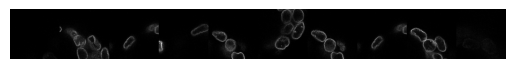

In [11]:
plt.imshow(samples[0, 0, 0, ...], cmap="gray")
plt.axis('off')